In [1]:
import pandas as pd
from darts import TimeSeries
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    """
    Function to fix and standardize datetime in the given DataFrame.
    
    Parameters:
    - X: DataFrame to be modified.
    - name: String representing the name of the DataFrame, used for logging.
    
    Returns:
    - Modified DataFrame with standardized datetime.
    """

    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')

    # Sort DataFrame by the new datetime column ('ds') and set it as the index
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Log the shape of the DataFrame before dropping rows with in-between minutes
    print(f"Shape of {name} before dropping in-between hour rows: ", X.shape)

    # Identify and log gaps in the date sequence
    print(f"HEIHEI: {name} gaps in dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())
    print(f"HEIHEI: {name} first gap in dates: ", X[X.index.to_series().diff().dt.total_seconds().gt(60*15)==True].index[:1])

    # Calculate and log the size of each gap in the date sequence
    temp = X.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print(f"HEIHEI: {name} list of size (in days) of each gap: ", temp[temp.gt(60*15)].values / (60*60*24))
    
    # temporarily transform into darts time series to fill missing dates
    # get date_calc if date_calc is column in X
    temp_calc = None
    if "date_calc" in X.columns:
        temp_calc = X["date_calc"]
        X.drop(columns=['date_calc'], inplace=True)
    X = TimeSeries.from_dataframe(df=X, freq="15T", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    if temp_calc is not None:
        X["date_calc"] = temp_calc

    print(f"HEIHEI: {name} gaps in dates after filling missing dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())


    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]

    # Log the shape of the DataFrame after dropping rows with in-between minutes
    print(f"Shape of {name} after dropping in-between hour rows: ", X.shape)

    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




# location_map = {
#     "A": 0,
#     "B": 1,
#     "C": 2
# }


def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)


    # # cast all columns to float64
    # X_train = X_train.astype('float64')
    # X_test = X_test.astype('float64')


    print(f"X_train_observed shape: {X_train_observed.shape}")
    print(f"X_train_estimated shape: {X_train_estimated.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")



    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    print("y_train columns: ", y_train.columns)

    # temporarily transform into darts time series to fill missing dates
    print("Shape of y_train before filling missing dates: ", y_train.shape)
    y_train = TimeSeries.from_dataframe(df=y_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("Shape of y_train after filling missing dates: ", y_train.shape)


    # number of gaps in X_train_observed + X_train_estimated before
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated before: ", X_train_observed.index.to_series().diff().dt.total_seconds().gt(3600).sum() + X_train_estimated.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    X_train = pd.concat([X_train_observed, X_train_estimated])
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated after: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    # print size of gaps in X_train
    temp = X_train.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print("LOOK: list of size (in days) of each gap: ", temp[temp.gt(3600)].values / (60*60*24))
    print("if the number is bigger after than before that means there is a gap in time between the observed and estimated training sets")

    # print info on dates in X_train, and if there are any missing dates
    print("X_train dates info: ", X_train.index.min(), X_train.index.max(), X_train.index.max() - X_train.index.min())
    print("X_test dates info: ", X_test.index.min(), X_test.index.max(), X_test.index.max() - X_test.index.min())
    print("y_train dates info: ", y_train.index.min(), y_train.index.max(), y_train.index.max() - y_train.index.min())

    # any gaps in dates?
    print("X_train gaps in dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("y_train gaps in dates: ", y_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    # temporarily transform into darts time series to fill missing dates
    X_train = TimeSeries.from_dataframe(df=X_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    X_test = TimeSeries.from_dataframe(df=X_test, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("X_train gaps in dates after filling missing dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates after filling missing dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    # print Number of missing values in X train
    print("Number of missing values in X_train: ", X_train.isnull().sum().sum())
    print("Number of missing values in X_test: ", X_test.isnull().sum().sum())
    # y_train missing values
    print("Number of missing values in y_train: ", y_train.isnull().sum().sum())
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)
    print("Number of missing values in X_train after merging with y_train: ", X_train.drop(columns=['y']).isnull().sum().sum())



    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
    


# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
y_trains = []
# Loop through locations
for loc in locations:
    print("\n\n")
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Concatenate observed and estimated datasets for each location
    #X_train = pd.concat([X_train_estimated, X_train_observed])
    



    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    print(f"Final shape of X_train for location {loc}: ", X_train.shape)
    print(f"Final shape of X_test for location {loc}: ", X_test.shape)

    # print(y_train.head(), y_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(type(X_train['y']))

    # Save data to csv
    X_train.to_csv(f'{loc}/X_train.csv', index=True)
    X_test.to_csv(f'{loc}/X_test.csv', index=True)


    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)


# temporary
# X_train["hour"] = X_train.index.hour
# X_train["weekday"] = X_train.index.weekday
# X_train["month"] = X_train.index.month
# X_train["year"] = X_train.index.year

# X_test["hour"] = X_test.index.hour
# X_test["weekday"] = X_test.index.weekday
# X_test["month"] = X_test.index.month
# X_test["year"] = X_test.index.year

print(f"Final shape of X_train: ", X_train.shape)
print(f"Final shape of X_test: ", X_test.shape)

#X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)




Processing location A...
Shape of X_train_observed before dropping in-between hour rows:  (118669, 45)
HEIHEI: X_train_observed gaps in dates:  0
HEIHEI: X_train_observed first gap in dates:  DatetimeIndex([], dtype='datetime64[ns]', name='ds', freq=None)
HEIHEI: X_train_observed list of size (in days) of each gap:  []
HEIHEI: X_train_observed gaps in dates after filling missing dates:  0
Shape of X_train_observed after dropping in-between hour rows:  (29668, 45)
Shape of X_train_estimated before dropping in-between hour rows:  (17576, 46)
HEIHEI: X_train_estimated gaps in dates:  1
HEIHEI: X_train_estimated first gap in dates:  DatetimeIndex(['2023-01-27'], dtype='datetime64[ns]', name='ds', freq=None)
HEIHEI: X_train_estimated list of size (in days) of each gap:  [1.01041667]
HEIHEI: X_train_estimated gaps in dates after filling missing dates:  0
Shape of X_train_estimated after dropping in-between hour rows:  (4418, 46)
Shape of X_test before dropping in-between hour rows:  (2880

# Starting

In [2]:
import os
# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}_ts'

Last submission number: 77
Now creating submission number: 78


In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
train_data = TabularDataset('X_train_raw.csv')

# get only location A
train_data = train_data[train_data["location"] == "A"]

train_data = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column="location",
    timestamp_column="ds",
)

#print(train_data.freq)

train_data = train_data.fill_missing_values(method="constant", value=0)

label = 'y'
time_limit = 60
presets = 'best_quality'


prediction_length=1536
eval_metric="RMSE"

In [4]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target=label,
    # all columns in train_data except target and ds columns are used as features
    known_covariates_names=train_data.columns.drop([label]),
    eval_metric=eval_metric,
    path=f"AutogluonModels/{new_filename}",
)

predictor.fit(
    train_data,
    presets=presets,
    time_limit=time_limit,
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': {'num_trials': 3,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'num_val_windows': 1,
 'prediction_length': 1536,
 'random_seed': None,
 'target': 'y',
 'time_limit': 60,
 'verbosity': 2}
Provided training data set with 110164 rows, 3 items (item = single time series). Average time series length is 36721.3. Data frequency is 'H'.


AutoGluon will save models to AutogluonModels/submission_78_ts/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'y'
	known covariates: Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kg

  0%|          | 0/3 [00:00<?, ?it/s]

	Stopping HPO to satisfy time limit...
	Trained 1 models while tuning DeepAR.
	-905.8763     = Validation score (-RMSE)
	25.16   s     = Total tuning time
Hyperparameter tuning model: TemporalFusionTransformer. Tuning model for up to 6.00s of the 59.98s remaining.


: 

In [ ]:
predictors = [predictor, predictor, predictor]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictors = [predictor, predictor, predictor]                                               │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'predictor' is not defined

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 │   i = location_map[loc]                                                                   │
│   10 │   subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True    │
│   11 │   #print(subset)                                                                          │
│ ❱ 12 │   pred = predictors[i].predict(subset)                                                    │
│   13 │   subset["prediction"] = pred                                                             │
│   14 │   predictions.append(subset)                                                              │
│   15                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'predictors' is not defined

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 │   train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax    │
│    6 │                                                                                           │
│    7 │   # plot predictions                                                                      │
│ ❱  8 │   predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")               │
│    9 │                                                                                           │
│   10 │   # title                                                                                 │
│   11 │   ax.set_title(f"Predictions for location {loc}")                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

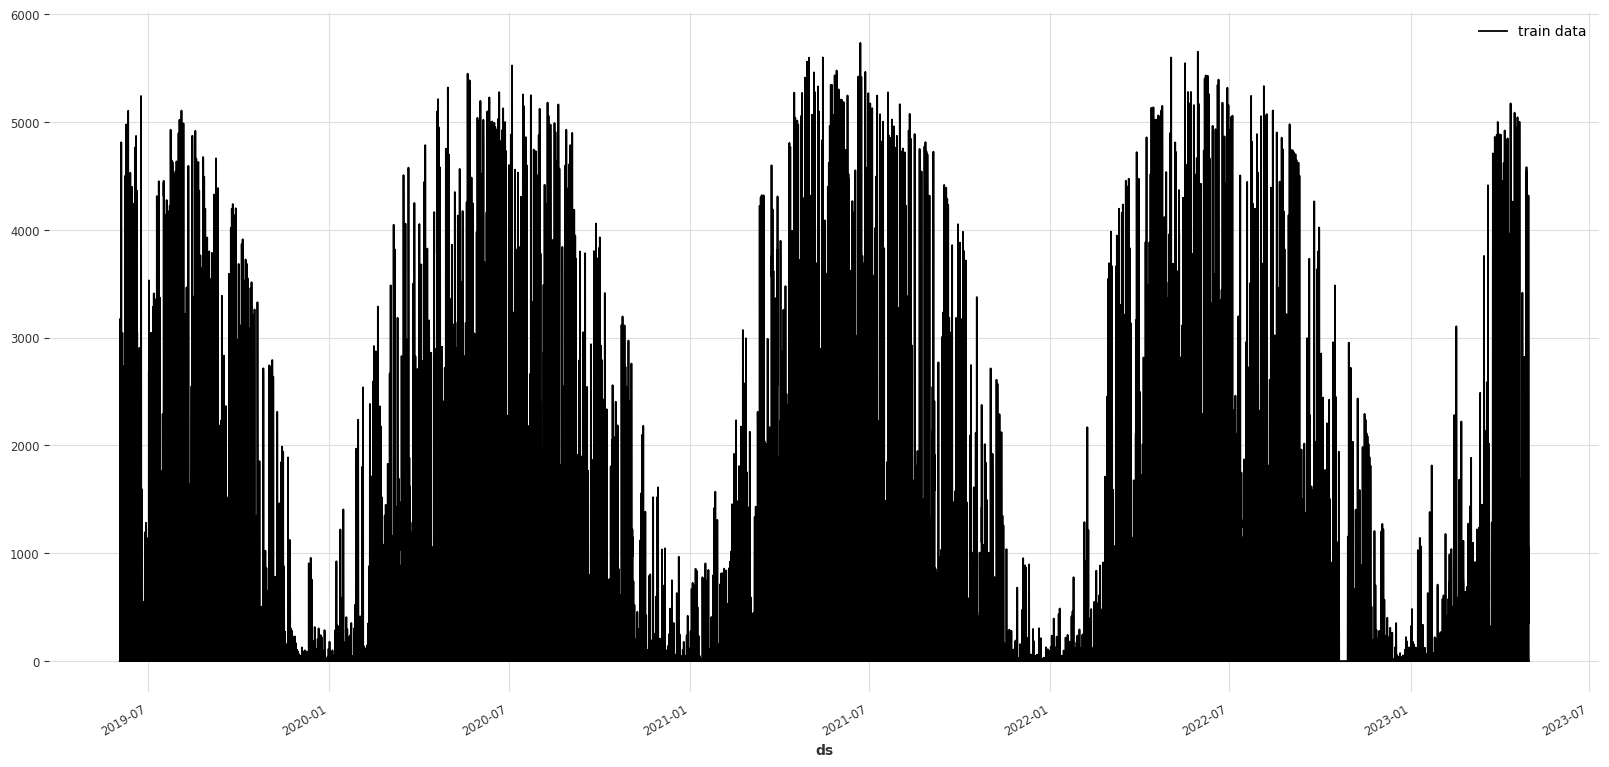

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # concatenate predictions                                                                    │
│ ❱ 2 submissions_df = pd.concat(predictions)                                                      │
│   3 submissions_df = submissions_df[["id", "prediction"]]                                        │
│   4 submissions_df                                                                               │
│   5                                                                                              │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/pandas/util/_decorators.py:331 in   │
│ wrapper                                                                                          │
│                                                                                                  │
│   328 │   │   │   │   │   FutureWarning,                                                         │
│   329 │   │   │   │   │   stacklevel=find_stack_level(),                                         │
│   330 │   │   │   │   )                                                                          │
│ ❱ 331 │   │   │   return func(*args, **kwargs)                                                   │
│   332 │   │                                                                                      │
│   333 │   │   # error: "Callable[[VarArg(Any), KwArg(Any)], Any]" has no                         │
│   334 │   │   # attribute "__signature__"                                                        │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/pandas/core/reshape/concat.py:368   │
│ in concat                                                                                        │
│                                                                                                  │
│   365 │   0   1   2                                                                              │
│   366 │   1   3   4                                                                              │
│   367 │   """                                                                                    │
│ ❱ 368 │   op = _Concatenator(                                                                    │
│   369 │   │   objs,                                                                              │
│   370 │   │   axis=axis,                                                                         │
│   371 │   │   ignore_index=ignore_index,                                                         │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/pandas/core/reshape/concat.py:425   │
│ in __init__                                                                                      │
│                                                                                                  │
│   422 │   │   │   objs = list(objs)                                                              │
│   423 │   │                                                                                      │
│   424 │   │   if len(objs) == 0:                                                                 │
│ ❱ 425 │   │   │   raise ValueError("No objects to concatenate")                                  │
│   426 │   │                                                                                      │
│   427 │   │   if keys is None:                             

In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_72.csv


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│   2                                                                                              │
│   3 # Save the submission                                                                        │
│   4 print(f"Saving submission to submissions/{new_filename}.csv")                                │
│ ❱ 5 submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)       │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'submissions_df' is not defined

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Writing 167359 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 134933 bytes to notebook_pdfs/submission_72.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_72.pdf', 'autogluon_each_location.ipynb'], returncode=0)